# Understanding Sovereign Default Events Using a Machine Learning Approach

Developed by: Michael Arias (2024), Pontificia Universidad Javeriana

## Libraries

On this section, the packages required to develop the exercise are loaded.

In [1]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import make_pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import pydot
from sklearn.tree import plot_tree
from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MultiLabelBinarizer

## Data Understanding

The file "IA Model 2" contains the data from the World Bank and the Bank of Canada (Sovereign Default)
- World Bank, World Development Indicators: https://databank.worldbank.org/source/world-development-indicators
- Bank of Canada, Sovereign Default Database: https://www.bankofcanada.ca/2023/07/staff-analytical-note-2023-10/


In [2]:
#Import the data
df = pd.read_excel('C:/Users/User/Desktop/Michael/Thesis/IA Model 2.xlsx')

In [3]:
df = df.drop(columns=["Unnamed: 64", "Unnamed: 65"])


In [4]:
df.head()

,Country Name,Series Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,Access to clean fuels and technologies for coo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.7,24.3,25.7,27.25,28.5,30.0,31.1,32.45,33.8,35.4
1,Albania,Access to clean fuels and technologies for coo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.4,72.3,74.4,76.10,77.6,79.0,80.2,81.60,82.7,83.7
2,Algeria,Access to clean fuels and technologies for coo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.4,99.4,99.5,99.60,99.6,99.6,99.6,99.70,99.7,99.7
3,American Samoa,Access to clean fuels and technologies for coo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,Access to clean fuels and technologies for coo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,100.0,100.0,100.00,100.0,100.0,100.0,100.00,100.0,100.0


In [5]:
df['Country Name'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Faroe Islands',

In the first column are the countries, while in the second column is the information related to the different variables present on the dataset, while on the remaining columns is the information from 1960 - 2021. Is necesary to perform different transformations on the dataframe.

## Data Preparation

Following CRISP DM, the next step is Data Preparation. Performing the transformations required identified on the Data Understanding phase.

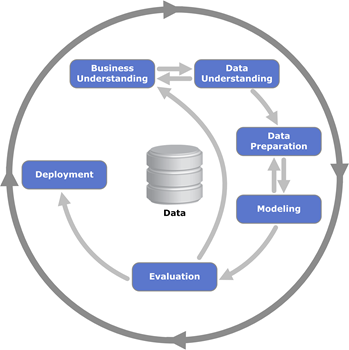


In [6]:
# Imput missing values with the average of each country & variable
def fillna_with_row_mean(row):
    non_nan_values = row.iloc[2:]  # Ignore the first two columns (Country & Variables)
    row_mean = non_nan_values.mean()
    return row.fillna(row_mean)

df = df.apply(fillna_with_row_mean, axis=1)

In [7]:
# Unify names
df.loc[df['Country Name'] == 'Bahamas, The', 'Country Name'] = 'Bahamas'
df.loc[df['Country Name'] == 'Congo, Rep.', 'Country Name'] = 'Congo, Dem. Rep.'
df.loc[df['Country Name'] == 'Egypt, Arab Rep.', 'Country Name'] = 'Egypt'
df.loc[df['Country Name'] == 'Faeroe Islands', 'Country Name'] = 'Faroe Islands'

In [8]:
# Pivot and melt the table
df = df.melt(id_vars=['Country Name', 'Series Name'], var_name='Year', value_name='Value')
df = df.pivot_table(index=['Country Name', 'Year'], columns='Series Name', values='Value').reset_index()
df = df.rename(columns={'Country Name': 'C'})

In [9]:
#Exclude regions on the Country column
exclude = [
    'Africa Eastern and Southern',
    'Africa Western and Central',
    'Arab World',
    'Caribbean small states',
    'Central African Republic',
    'Central Europe and the Baltics',
    'Early-demographic dividend',
    'East Asia & Pacific',
    'East Asia & Pacific (IDA & IBRD countries)',
    'East Asia & Pacific (IDA & IBRD)',
    'East Asia & Pacific (excluding high income)',
    'Euro area',
    'Europe & Central Asia',
    'Europe & Central Asia (IDA & IBRD countries)',
    'Europe & Central Asia (IDA & IBRD)',
    'Europe & Central Asia (excluding high income)',
    'European Union',
    'Fragile and conflict affected situations',
    'Heavily indebted poor countries (HIPC)',
    'High income',
    'IBRD only',
    'IDA & IBRD total',
    'IDA blend',
    'IDA only',
    'IDA total',
    'Late-demographic dividend',
    'Latin America & Caribbean',
    'Latin America & Caribbean (IDA & IBRD)',
    'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'Least developed countries: UN classification',
    'Low & middle income',
    'Low income',
    'Lower middle income',
    'Middle East & North Africa',
    'Middle East & North Africa (IDA & IBRD countries)',
    'Middle East & North Africa (IDA & IBRD)',
    'Middle East & North Africa (excluding high income)',
    'Middle income',
    'North America',
    'OECD members',
    'Other small states',
    'Pacific island small states',
    'Post-demographic dividend',
    'Pre-demographic dividend',
    'Small states',
    'South Asia',
    'South Asia (IDA & IBRD)',
    'Sub-Saharan Africa',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Sub-Saharan Africa (IDA & IBRD)',
    'Sub-Saharan Africa (excluding high income)',
    'Upper middle income',
    'West Bank and Gaza',
    'World'
]

df = df[~df['C'].isin(exclude)]

In [10]:
# Re-group the table
df = df.groupby(['C', 'Year']).sum().reset_index()

# Dummify
df=pd.get_dummies(df, columns= ['C'])
df=pd.get_dummies(df, columns= ['Year'])

In [11]:
df.filter(regex=r"^Year").columns.tolist()

['Year_1960',
 'Year_1961',
 'Year_1962',
 'Year_1963',
 'Year_1964',
 'Year_1965',
 'Year_1966',
 'Year_1967',
 'Year_1968',
 'Year_1969',
 'Year_1970',
 'Year_1971',
 'Year_1972',
 'Year_1973',
 'Year_1974',
 'Year_1975',
 'Year_1976',
 'Year_1977',
 'Year_1978',
 'Year_1979',
 'Year_1980',
 'Year_1981',
 'Year_1982',
 'Year_1983',
 'Year_1984',
 'Year_1985',
 'Year_1986',
 'Year_1987',
 'Year_1988',
 'Year_1989',
 'Year_1990',
 'Year_1991',
 'Year_1992',
 'Year_1993',
 'Year_1994',
 'Year_1995',
 'Year_1996',
 'Year_1997',
 'Year_1998',
 'Year_1999',
 'Year_2000',
 'Year_2001',
 'Year_2002',
 'Year_2003',
 'Year_2004',
 'Year_2005',
 'Year_2006',
 'Year_2007',
 'Year_2008',
 'Year_2009',
 'Year_2010',
 'Year_2011',
 'Year_2012',
 'Year_2013',
 'Year_2014',
 'Year_2015',
 'Year_2016',
 'Year_2017',
 'Year_2018',
 'Year_2019',
 'Year_2020',
 'Year_2021']

In [12]:
# Drop specific columns by name
columns_to_drop = ['Net official flows from UN agencies, UNEP (current US$)', 'Net official flows from UN agencies, UNIDIR (current US$)']
df = df.drop(columns=columns_to_drop)

In [13]:
df.describe()

,ARI treatment (% of children under 5 taken to a health provider),Access to clean fuels and technologies for cooking (% of population),"Access to clean fuels and technologies for cooking, rural (% of rural population)","Access to clean fuels and technologies for cooking, urban (% of urban population)",Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)",...,"Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
count,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,...,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000,14942.000000
mean,30.395371,49.446690,43.029225,56.618620,70.755597,64.488901,78.853517,36.759279,34.727424,38.786501,...,14.669124,12.004783,7.111939,4.130791,7.938303,8.950528,5.539827,13.180055,26.532389,2424.334848
std,32.995336,43.192228,43.645033,43.480072,37.603641,40.989950,34.373452,35.318652,34.892460,35.960371,...,25.619274,21.875001,14.470048,8.920847,15.842907,16.670779,12.047294,16.735151,21.793411,11539.060510
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.838636,0.250000,1.954545,37.978482,16.218944,71.210060,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,46.050000,22.811364,75.454545,95.700000,91.037815,99.066151,31.050000,26.555000,34.425000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.700000,26.859375,100.000000
75%,62.700000,99.775000,99.300000,99.900000,100.000000,100.000000,100.000000,69.442500,64.505000,70.730000,...,28.675000,18.300000,5.350000,2.900000,5.800000,11.700000,2.700000,24.150000,44.700000,500.000000
max,97.500000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,92.800000,92.100000,77.600000,64.500000,82.700000,81.000000,73.500000,83.500000,89.700000,230000.000000


Now, the distance between the average and the median is shorter than before.

In [14]:
df.shape

(14942, 1789)

In [15]:
#Check the statistics for random columns
random_columns = df.sample(10, axis=1)
random_columns.describe()

,CPIA quality of public administration rating (1=low to 6=high),Multidimensional poverty intensity (average share of deprivations experienced by the poor),Population in urban agglomerations of more than 1 million,Compensation of employees (current LCU),"PM2.5 pollution, population exposed to levels exceeding WHO Interim Target-1 value (% of total)","Population ages 00-04, male (% of male population)","School enrollment, tertiary, female (% gross)"
count,14942.000000,14942.000000,1.494200e+04,1.494200e+04,14942.000000,14942.000000,14942.000000
mean,1.040240,5.192481,4.199658e+06,1.121450e+12,19.255219,11.158790,22.723105
std,1.440951,14.489906,1.845484e+07,1.061420e+13,34.768469,6.042791,26.482417
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,6.805669,1.059280
50%,0.000000,0.000000,0.000000e+00,1.428902e+09,0.000000,11.198439,11.872067
75%,2.617647,0.000000,1.815592e+06,5.359263e+10,18.424487,16.660997,37.511601
max,4.000000,58.000000,4.204594e+08,3.848599e+14,100.000000,24.086297,156.148895


In [16]:
# Get the default variables
variables_default = [col for col in df.columns if col.startswith('DEFAULT')]

# save on Y the default variables
Y = df[variables_default]

# The last variables are located on X
X = df.drop(variables_default, axis=1)

In [17]:
# Calculate the proportions on the new data set
proportions = Y.mean()

print("Proportions of 1s over total for each variable:")
print(proportions)

Proportions of 1s over total for each variable:
DEFAULT_CHINA                       0.099987
DEFAULT_FC_BANK_LOANS               0.067996
DEFAULT_FC_BONDS                    0.031455
DEFAULT_FISCAL_ARREARS              0.177955
DEFAULT_IADB                        0.001472
DEFAULT_IBRD                        0.011511
DEFAULT_IDA                         0.013854
DEFAULT_IMF                         0.022018
DEFAULT_LC_DEFAULT                  0.017735
DEFAULT_OTHER_OFFICIAL_CREDITORS    0.284701
DEFAULT_PARIS_CLUB                  0.088810
DEFAULT_PRIVATE_CREDITORS           0.193615
dtype: float64


In [18]:
numeric_cols = X.select_dtypes(include=["number"]).columns

In [19]:
numeric_cols = X.select_dtypes(include=["number"]).columns
numeric_cols = [c for c in numeric_cols if X[c].nunique() > 2]

In [20]:
def outlier_ratio(series):
    series = series.dropna()
    if series.nunique() <= 1:
        return 0.0

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    if iqr == 0:
        return 0.0

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    return ((series < lower) | (series > upper)).mean()


In [21]:
outlier_threshold = 0.02

outlier_features = []
normal_features = []

for col in numeric_cols:
    ratio = outlier_ratio(X[col])
    if ratio > outlier_threshold:
        outlier_features.append(col)
    else:
        normal_features.append(col)


In [22]:
from sklearn.preprocessing import RobustScaler, StandardScaler

X_scaled = X.copy()

# Variables con outliers
robust_scaler = RobustScaler()
X_scaled[outlier_features] = robust_scaler.fit_transform(X[outlier_features])

# Variables normales (opcional)
standard_scaler = StandardScaler()
X_scaled[normal_features] = standard_scaler.fit_transform(X[normal_features])

In [23]:
# Validación temporal
test_mask = (df["Year_2020"] == 1) | (df["Year_2021"] == 1)

X_train = X_scaled.loc[~test_mask].copy()
X_test  = X_scaled.loc[test_mask].copy()

y_train = Y.loc[~test_mask].copy()
y_test  = Y.loc[test_mask].copy()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14460, 1777) (482, 1777) (14460, 12) (482, 12)


### Data Balance

In order to balance the dataset, the ensemble method is applied to balance the dataframe.

In [21]:
# Define a base classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=69)

# Define oversampling methods
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

# Create pipelines for each oversampling method
pipelines = {
    'Random Oversampling': make_pipeline(ros, clf),
    'SMOTE': make_pipeline(smote, clf),
    'ADASYN': make_pipeline(adasyn, clf),
    'No Oversampling': clf}  # No oversampling

In [18]:
# Iterate over each column in Y
for col in Y.columns:
    # Create the DataFrame for X with the variables that do not include the current column
    X_resampled = X

    # Select the current column from Y for cross-validation
    y_resampled = Y[col]

    # Perform cross-validation and compare performance
    print(f"\nVariable: {col}")
    for name, pipeline in pipelines.items():
        scores = cross_val_score(pipeline, X_resampled, y_resampled, scoring='f1', cv=5)
        print(f'{name}: Mean F1-Score {np.mean(scores):.3f}, Standard Deviation {np.std(scores):.3f}')


Variable: DEFAULT_CHINA
Random Oversampling: Mean F1-Score 0.279, Standard Deviation 0.079
SMOTE: Mean F1-Score 0.312, Standard Deviation 0.078
ADASYN: Mean F1-Score 0.309, Standard Deviation 0.071
No Oversampling: Mean F1-Score 0.137, Standard Deviation 0.076

Variable: DEFAULT_FC_BANK_LOANS
Random Oversampling: Mean F1-Score 0.218, Standard Deviation 0.053
SMOTE: Mean F1-Score 0.239, Standard Deviation 0.049
ADASYN: Mean F1-Score 0.232, Standard Deviation 0.043
No Oversampling: Mean F1-Score 0.067, Standard Deviation 0.042

Variable: DEFAULT_FC_BONDS
Random Oversampling: Mean F1-Score 0.097, Standard Deviation 0.052
SMOTE: Mean F1-Score 0.096, Standard Deviation 0.051
ADASYN: Mean F1-Score 0.110, Standard Deviation 0.036
No Oversampling: Mean F1-Score 0.055, Standard Deviation 0.068

Variable: DEFAULT_FISCAL_ARREARS
Random Oversampling: Mean F1-Score 0.414, Standard Deviation 0.058
SMOTE: Mean F1-Score 0.462, Standard Deviation 0.026
ADASYN: Mean F1-Score 0.470, Standard Deviation 0

In [24]:
priority = [
    "DEFAULT_IADB",
    "DEFAULT_IBRD",
    "DEFAULT_IDA",
    "DEFAULT_LC_DEFAULT",
    "DEFAULT_IMF",
    "DEFAULT_FC_BONDS",
    "DEFAULT_FC_BANK_LOANS",
    "DEFAULT_PARIS_CLUB",
    "DEFAULT_CHINA",
    "DEFAULT_FISCAL_ARREARS",
    "DEFAULT_PRIVATE_CREDITORS",
    "DEFAULT_OTHER_OFFICIAL_CREDITORS",
]

def collapse_to_multiclass(row):
    for col in priority:
        if row[col] == 1:
            return col
    return "NO_DEFAULT"

y_multiclass = Y.apply(collapse_to_multiclass, axis=1)

In [26]:
y_train_multiclass = y_train.apply(collapse_to_multiclass, axis=1)
y_test_multiclass = y_test.apply(collapse_to_multiclass, axis=1)

In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train,
    y_train_multiclass
)

In [28]:
y_train_resampled.value_counts(normalize=True)

NO_DEFAULT                          0.076923
DEFAULT_OTHER_OFFICIAL_CREDITORS    0.076923
DEFAULT_IMF                         0.076923
DEFAULT_IDA                         0.076923
DEFAULT_FISCAL_ARREARS              0.076923
DEFAULT_CHINA                       0.076923
DEFAULT_PARIS_CLUB                  0.076923
DEFAULT_PRIVATE_CREDITORS           0.076923
DEFAULT_FC_BANK_LOANS               0.076923
DEFAULT_LC_DEFAULT                  0.076923
DEFAULT_FC_BONDS                    0.076923
DEFAULT_IBRD                        0.076923
DEFAULT_IADB                        0.076923
Name: proportion, dtype: float64

<Figure size 640x480 with 0 Axes>

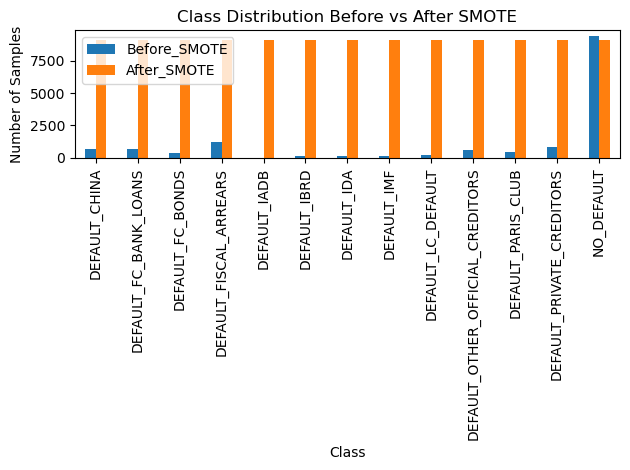

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Count distributions
before_counts = y_multiclass.value_counts().sort_index()
after_counts = y_train_resampled.value_counts().sort_index()

# Align indices
df_counts = pd.DataFrame({
    "Before_SMOTE": before_counts,
    "After_SMOTE": after_counts
}).fillna(0)

# Plot
plt.figure()
df_counts.plot(kind="bar")
plt.title("Class Distribution Before vs After SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

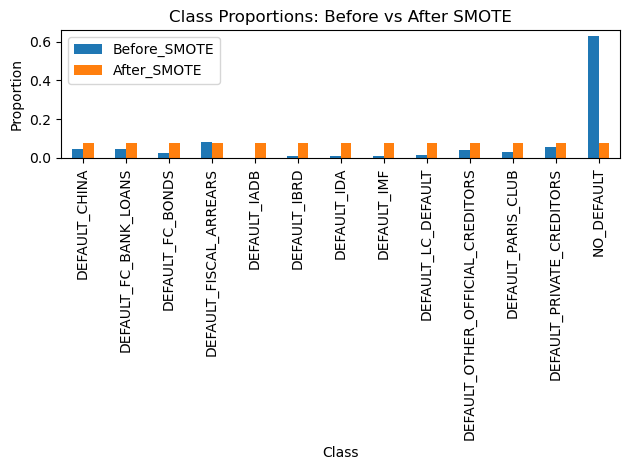

In [31]:
df_props = df_counts.div(df_counts.sum(axis=0), axis=1)

plt.figure(figsize=(12, 6))
df_props.plot(kind="bar")
plt.title("Class Proportions: Before vs After SMOTE")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Modeling

Models to apply:
- Fuzzy Decision Trees
- AdaBoost
- XGBoost
- Deep Learning Neural Decision Trees (Error - Not deployed)
- Support Vector Machines (Error - Not deployed)
- Artificial Neuronal Networks

### Feature Selection

In [32]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.01)
X_train_vt = vt.fit_transform(X_train_resampled)
X_test_vt = vt.transform(X_test)

selected_features_vt = X_train_resampled.columns[vt.get_support()]

In [33]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(
    X_train_resampled,
    y_train_resampled,
    discrete_features="auto",
    random_state=42
)

mi_scores = pd.Series(mi, index=X_train_resampled.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [34]:
mi_sorted = mi_scores.sort_values(ascending=False)

mi_cum = mi_sorted.cumsum()
mi_cum_ratio = mi_cum / mi_cum.iloc[-1]

K_90 = (mi_cum_ratio <= 0.90).sum()
K_95 = (mi_cum_ratio <= 0.95).sum()

K_90, K_95

(1208, 1318)

In [35]:
top_k = 1208
selected_features_mi = mi_scores.head(top_k).index

X_train_fs = X_train_resampled[selected_features_mi]
X_test_fs = X_test[selected_features_mi]

In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train_resampled)
y_test_enc = le.transform(y_test_multiclass)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# One-hot encode target
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

num_features = X_train_fs.shape[1]
num_classes = y_train_cat.shape[1]

model = Sequential([
    Dense(512, activation='relu', input_shape=(num_features,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
history = model.fit(
    X_train_fs,
    y_train_enc,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    verbose=1
)


Epoch 1/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2301 - loss: 4015762.7500 - val_accuracy: 4.2182e-05 - val_loss: 9006495.0000
Epoch 2/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2663 - loss: 1179772.6250 - val_accuracy: 0.0060 - val_loss: 330040.6562
Epoch 3/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2620 - loss: 103263.1016 - val_accuracy: 0.0073 - val_loss: 36.1698
Epoch 4/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2549 - loss: 2451.0981 - val_accuracy: 0.0076 - val_loss: 8.2155
Epoch 5/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2604 - loss: 1142.9114 - val_accuracy: 0.0023 - val_loss: 11.6140
Epoch 6/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2449 - loss: 912.1752 - val_accuracy: 0.0079 - val_loss: 12.5085
Epoch 7/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2516 - loss: 99.5417 - val_accuracy: 0.0077 - val_loss: 14.9788
Epoch 8/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accur

In [40]:
test_loss, test_acc = model.evaluate(X_test_fs, y_test_enc)
print(f"Test Accuracy: {test_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3083 - loss: 3.0108 
Test Accuracy: 0.3320


In [41]:
import numpy as np

y_pred_prob = model.predict(X_test_fs)
y_pred = np.argmax(y_pred_prob, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [42]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test_enc,
        y_pred,
        target_names=le.classes_,
        digits=4
    )
)


                                  precision    recall  f1-score   support

                   DEFAULT_CHINA     0.4444    0.1569    0.2319        51
           DEFAULT_FC_BANK_LOANS     0.6667    0.3333    0.4444         6
                DEFAULT_FC_BONDS     0.1818    0.1538    0.1667        13
          DEFAULT_FISCAL_ARREARS     0.3182    0.1818    0.2314        77
                    DEFAULT_IADB     0.0000    0.0000    0.0000         2
                    DEFAULT_IBRD     0.0357    0.6667    0.0678         3
                     DEFAULT_IDA     0.5000    0.1429    0.2222         7
                     DEFAULT_IMF     0.0000    0.0000    0.0000         0
              DEFAULT_LC_DEFAULT     0.0370    0.8000    0.0708        10
DEFAULT_OTHER_OFFICIAL_CREDITORS     0.0000    0.0000    0.0000        16
              DEFAULT_PARIS_CLUB     0.0000    0.0000    0.0000        42
       DEFAULT_PRIVATE_CREDITORS     0.0000    0.0000    0.0000        15
                      NO_DEFAULT     

c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classif

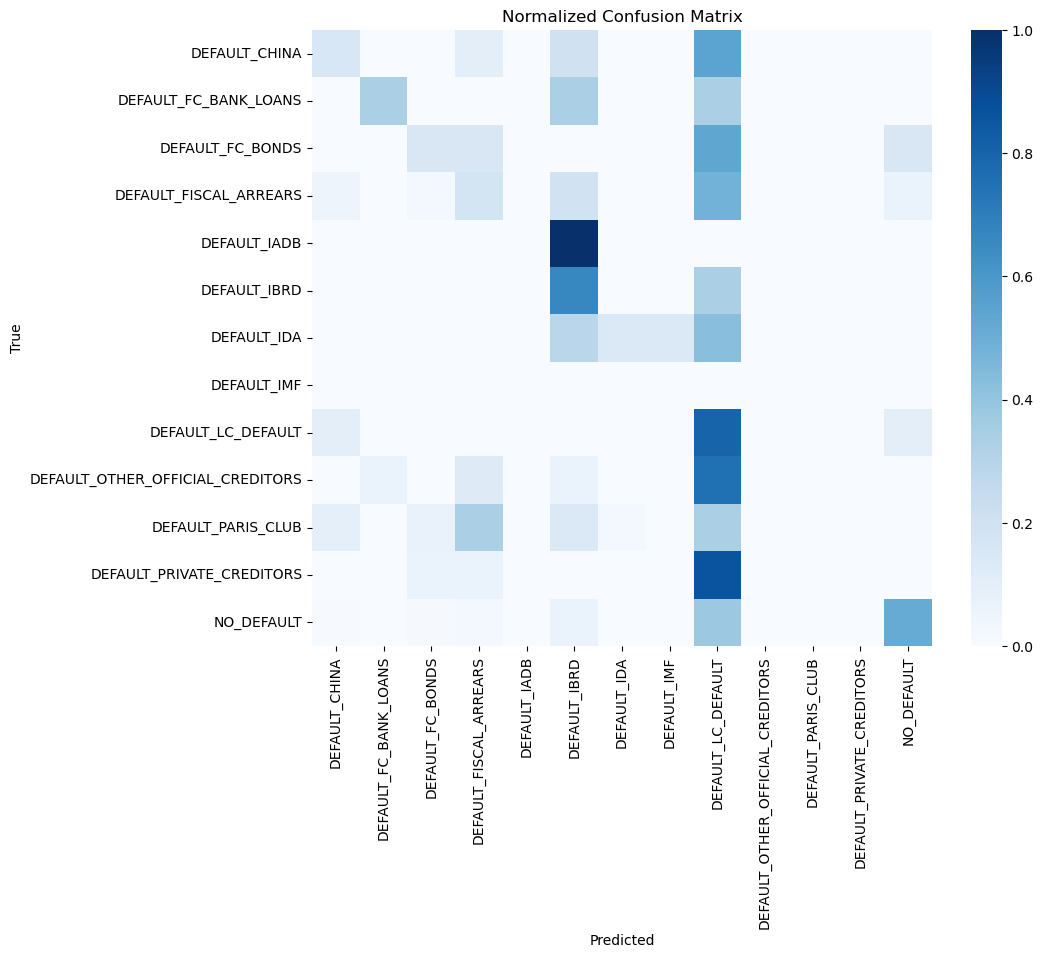

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_enc, y_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",
    annot=False
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()


In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1_macro = f1_score(y_test_enc, y_pred, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')

recall_macro = recall_score(y_test_enc, y_pred, average='macro')
precision_macro = precision_score(y_test_enc, y_pred, average='macro')

print(f"F1 macro:     {f1_macro:.4f}")
print(f"F1 weighted:  {f1_weighted:.4f}")
print(f"Recall macro: {recall_macro:.4f}")
print(f"Precision macro: {precision_macro:.4f}")


F1 macro:     0.1614
F1 weighted:  0.4068
Recall macro: 0.2268
Precision macro: 0.2402


c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras_tuner as kt

def build_model(hp):

    model = Sequential()

    # Número de capas ocultas
    n_layers = hp.Int("n_layers", min_value=2, max_value=5)

    for i in range(n_layers):
        units = hp.Choice(f"units_{i}", [64, 128, 256, 512])
        dropout = hp.Float(f"dropout_{i}", 0.1, 0.5, step=0.1)
        l2_reg = hp.Choice(f"l2_{i}", [1e-3, 1e-4, 1e-5])

        if i == 0:
            model.add(Dense(
                units,
                activation="relu",
                kernel_regularizer=l2(l2_reg),
                input_shape=(X_train_fs.shape[1],)
            ))
        else:
            model.add(Dense(
                units,
                activation="relu",
                kernel_regularizer=l2(l2_reg)
            ))

        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(len(le.classes_), activation="softmax"))

    lr = hp.Choice("learning_rate", [1e-2, 3e-3, 1e-3, 3e-4, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [60]:
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="nn_tuning",
    project_name="default_multiclass"
)


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [63]:
tuner.search(
    X_train_fs,
    y_train_enc,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)



Trial 90 Complete [00h 00m 32s]
val_loss: 4.331068992614746

Best val_loss So Far: 2.9193758964538574
Total elapsed time: 00h 32m 46s


In [64]:
best_model = tuner.get_best_models(num_models=1)[0]
    

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\User\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [65]:
best_hp = tuner.get_best_hyperparameters(1)[0]

for k, v in best_hp.values.items():
    print(f"{k}: {v}")


n_layers: 3
units_0: 256
dropout_0: 0.1
l2_0: 0.001
units_1: 128
dropout_1: 0.1
l2_1: 0.0001
learning_rate: 0.0001
units_2: 64
dropout_2: 0.2
l2_2: 1e-05
units_3: 128
dropout_3: 0.2
l2_3: 0.0001
units_4: 128
dropout_4: 0.30000000000000004
l2_4: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

num_features = X_train_fs.shape[1]
num_classes = len(le.classes_)

model = Sequential([

    Dense(
        256,
        activation="relu",
        kernel_regularizer=l2(0.001),
        input_shape=(num_features,)
    ),
    BatchNormalization(),
    Dropout(0.1),

    Dense(
        128,
        activation="relu",
        kernel_regularizer=l2(0.0001)
    ),
    BatchNormalization(),
    Dropout(0.1),

    Dense(
        64,
        activation="relu",
        kernel_regularizer=l2(1e-5)
    ),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    X_train_fs,
    y_train_enc,
    validation_split=0.2,
    epochs=80,
    batch_size=256,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0900 - loss: 3.2012 - val_accuracy: 0.0000e+00 - val_loss: 2.9156 - learning_rate: 1.0000e-04
Epoch 2/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1327 - loss: 2.6247 - val_accuracy: 0.0000e+00 - val_loss: 2.9677 - learning_rate: 1.0000e-04
Epoch 3/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1405 - loss: 2.5056 - val_accuracy: 0.0000e+00 - val_loss: 3.1042 - learning_rate: 1.0000e-04
Epoch 4/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1411 - loss: 2.4671 - val_accuracy: 0.0000e+00 - val_loss: 3.2627 - learning_rate: 1.0000e-04
Epoch 5/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1438 - loss: 2.4377 - val_accuracy: 0.0000e+00 - val_loss: 3.3288 - learning_rate: 5.0000e-05
Epoch 6/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1431 - loss: 2.4271 - val_accuracy: 0.0000e+00 - val_loss: 3.4677 - learning_rate: 5.0000e-05
Epoch 7/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 

In [48]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

y_pred = model.predict(X_test_fs).argmax(axis=1)

print(classification_report(
    y_test_enc,
    y_pred,
    target_names=le.classes_,
    digits=4
))

print("Macro F1:", f1_score(y_test_enc, y_pred, average="macro"))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                                  precision    recall  f1-score   support

                   DEFAULT_CHINA     0.3333    0.0196    0.0370        51
           DEFAULT_FC_BANK_LOANS     0.0000    0.0000    0.0000         6
                DEFAULT_FC_BONDS     0.0000    0.0000    0.0000        13
          DEFAULT_FISCAL_ARREARS     0.0000    0.0000    0.0000        77
                    DEFAULT_IADB     0.0000    0.0000    0.0000         2
                    DEFAULT_IBRD     0.0000    0.0000    0.0000         3
                     DEFAULT_IDA     0.0000    0.0000    0.0000         7
                     DEFAULT_IMF     0.0000    0.0000    0.0000         0
              DEFAULT_LC_DEFAULT     0.0000    0.0000    0.0000        10
DEFAULT_OTHER_OFFICIAL_CREDITORS     0.0000    0.0000    0.0000        16
              DEFAULT_PARIS_CLUB     0.0000    0.0000    0.0000        42
       DEFAULT_PRIVATE_CREDITORS     0.0000    0.0000    0.0000        1

c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classif

### XGBoost

In [52]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42
)


In [53]:
xgb_model.fit(
    X_train_fs,
    y_train_enc,
    eval_set=[(X_test_fs, y_test_enc)],
    early_stopping_rounds=30,
    verbose=True
)


c:\Users\User\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.42914
[1]	validation_0-mlogloss:2.32206
[2]	validation_0-mlogloss:2.23613
[3]	validation_0-mlogloss:2.15898
[4]	validation_0-mlogloss:2.09518
[5]	validation_0-mlogloss:2.04000
[6]	validation_0-mlogloss:1.98970
[7]	validation_0-mlogloss:1.94069
[8]	validation_0-mlogloss:1.90130
[9]	validation_0-mlogloss:1.86235
[10]	validation_0-mlogloss:1.82387
[11]	validation_0-mlogloss:1.79169
[12]	validation_0-mlogloss:1.75668
[13]	validation_0-mlogloss:1.72736
[14]	validation_0-mlogloss:1.69855
[15]	validation_0-mlogloss:1.67056
[16]	validation_0-mlogloss:1.64624
[17]	validation_0-mlogloss:1.62023
[18]	validation_0-mlogloss:1.59647
[19]	validation_0-mlogloss:1.57661
[20]	validation_0-mlogloss:1.55747
[21]	validation_0-mlogloss:1.53640
[22]	validation_0-mlogloss:1.51641
[23]	validation_0-mlogloss:1.49695
[24]	validation_0-mlogloss:1.47887
[25]	validation_0-mlogloss:1.46436
[26]	validation_0-mlogloss:1.44911
[27]	validation_0-mlogloss:1.43466
[28]	validation_0-mlogloss:1.4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=13, num_parallel_tree=None, ...)

In [42]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

y_pred = xgb_model.predict(X_test_fs)

print(classification_report(
    y_test_enc,
    y_pred,
    target_names=le.classes_,
    digits=4
))

print("Macro F1:", f1_score(y_test_enc, y_pred, average="macro"))
print("Weighted F1:", f1_score(y_test_enc, y_pred, average="weighted"))


                                  precision    recall  f1-score   support

                   DEFAULT_CHINA     0.6696    0.5357    0.5952       140
           DEFAULT_FC_BANK_LOANS     0.8182    0.6183    0.7043       131
                DEFAULT_FC_BONDS     0.8400    0.5385    0.6562        78
          DEFAULT_FISCAL_ARREARS     0.6681    0.6194    0.6429       247
                    DEFAULT_IADB     0.0000    0.0000    0.0000         4
                    DEFAULT_IBRD     0.0796    0.8438    0.1456        32
                     DEFAULT_IDA     0.7143    0.6000    0.6522        25
                     DEFAULT_IMF     0.2903    0.3214    0.3051        28
              DEFAULT_LC_DEFAULT     0.6000    0.6136    0.6067        44
DEFAULT_OTHER_OFFICIAL_CREDITORS     0.6190    0.5200    0.5652       125
              DEFAULT_PARIS_CLUB     0.6049    0.4900    0.5414       100
       DEFAULT_PRIVATE_CREDITORS     0.6667    0.6626    0.6646       163
                      NO_DEFAULT     

In [54]:
import shap
import numpy as np
import pandas as pd

# Inicializar explainer (TreeExplainer es óptimo para XGBoost)
explainer = shap.TreeExplainer(xgb_model)

# Calcular SHAP values en test set
shap_values = explainer.shap_values(X_test_fs)

In [55]:
np.array(shap_values).shape


(482, 1208, 13)

In [56]:
import numpy as np
import pandas as pd

shap_array = np.array(shap_values)  # (samples, features, classes)

mean_abs_shap = np.mean(
    np.abs(shap_array),
    axis=(0, 2)   # promedio sobre samples y clases
)

global_importance = pd.Series(
    mean_abs_shap,
    index=X_test_fs.columns
).sort_values(ascending=False)

global_importance.head(20)

Government Effectiveness: Percentile Rank, Lower Bound of 90% Confidence Interval    0.062840
Total reserves (% of total external debt)                                            0.057571
Total reserves minus gold (current US$)                                              0.052681
Population density (people per sq. km of land area)                                  0.051086
Renewable internal freshwater resources per capita (cubic meters)                    0.050292
Export value index (2015 = 100)                                                      0.050160
Access to electricity (% of population)                                              0.046501
GDP deflator: linked series (base year varies by country)                            0.044142
Access to electricity, urban (% of urban population)                                 0.043884
Women Business and the Law Index Score (scale 1-100)                                 0.043710
Net financial flows, IDA (NFL, current US$)                 

In [57]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_multiclass)  # el vector original en string

class_names = le.classes_

In [58]:
class_names = [
    "DEFAULT_CHINA",
    "DEFAULT_FC_BANK_LOANS",
    "DEFAULT_FC_BONDS",
    "DEFAULT_FISCAL_ARREARS",
    "DEFAULT_IADB",
    "DEFAULT_IBRD",
    "DEFAULT_IDA",
    "DEFAULT_IMF",
    "DEFAULT_LC_DEFAULT",
    "DEFAULT_OTHER_OFFICIAL_CREDITORS",
    "DEFAULT_PARIS_CLUB",
    "DEFAULT_PRIVATE_CREDITORS",
    "NO_DEFAULT"
]

shap_by_class = {}

for class_idx, class_name in enumerate(class_names):
    shap_class = np.abs(shap_array[:, :, class_idx]).mean(axis=0)

    shap_by_class[class_name] = pd.Series(
        shap_class,
        index=X_test_fs.columns
    ).sort_values(ascending=False)

shap_by_class["DEFAULT_CHINA"].head(15)



Net financial flows, IDA (NFL, current US$)                                0.442476
DEC alternative conversion factor (LCU per US$)                            0.231618
GDP deflator (base year varies by country)                                 0.103242
Gross fixed capital formation (current US$)                                0.090894
Time to export, documentary compliance (hours)                             0.082383
Arms exports (SIPRI trend indicator values)                                0.061247
UHC service coverage index                                                 0.055665
School enrollment, primary, private (% of total primary)                   0.053488
Domestic general government health expenditure per capita (current US$)    0.052270
Import unit value index (2015 = 100)                                       0.049628
Net foreign assets (current LCU)                                           0.047301
High-technology exports (current US$)                                      0

In [59]:
shap_by_class["DEFAULT_IMF"].head(30)

Total reserves minus gold (current US$)                                  0.589612
Adjusted savings: gross savings (% of GNI)                               0.342062
Fixed telephone subscriptions (per 100 people)                           0.294884
Net foreign assets (current LCU)                                         0.097475
Net bilateral aid flows from DAC donors, France (current US$)            0.086387
GDP deflator (base year varies by country)                               0.074527
Foreign direct investment, net (BoP, current US$)                        0.065217
Women Business and the Law Index Score (scale 1-100)                     0.064885
Total reserves (includes gold, current US$)                              0.063255
Refugee population by country or territory of origin                     0.057869
GDP per capita (current LCU)                                             0.057628
Adjusted net national income (current US$)                               0.055569
GDP deflator: li

In [60]:
class_idx = list(class_names).index("DEFAULT_IMF")

mean_signed_effect = pd.Series(
    shap_array[:, :, class_idx].mean(axis=0),
    index=X_test_fs.columns
).sort_values(ascending=False)

mean_signed_effect.head(15)

Adjusted net national income (current US$)                                                          0.042147
Individuals using the Internet (% of population)                                                    0.025646
GDP deflator: linked series (base year varies by country)                                           0.020805
Adjusted savings: education expenditure (current US$)                                               0.016116
GNI growth (annual %)                                                                               0.008563
Foreign direct investment, net (BoP, current US$)                                                   0.007297
Services, value added (current US$)                                                                 0.006616
Manufactures exports (% of merchandise exports)                                                     0.006390
Services, value added (annual % growth)                                                             0.006310
Educational attainm

In [61]:
import pandas as pd
import numpy as np

top_k = 15

for class_idx, class_name in enumerate(class_names):

    shap_class = shap_array[:, :, class_idx]

    # SHAP promedio con signo
    mean_signed = shap_class.mean(axis=0)

    df_class = pd.DataFrame({
        "feature": X_test_fs.columns,
        "mean_signed_shap": mean_signed,
        "mean_abs_shap": np.abs(mean_signed)
    })

    # Top que aumentan la probabilidad
    df_positive = (
        df_class
        .sort_values("mean_signed_shap", ascending=False)
        .head(top_k)
        .copy()
    )
    df_positive["direction"] = "increases_default_risk"

    # Top que reducen la probabilidad
    df_negative = (
        df_class
        .sort_values("mean_signed_shap", ascending=True)
        .head(top_k)
        .copy()
    )
    df_negative["direction"] = "reduces_default_risk"

    # Combinar en un solo DataFrame
    df_final = pd.concat([df_positive, df_negative], axis=0)

    # Añadir clase explícita
    df_final["class"] = class_name

    # Guardar un solo CSV por clase
    df_final.to_csv(
        f"shap_top30_signed_{class_name}.csv",
        index=False
    )


In [95]:
df_all = pd.concat(results, axis=0)

df_all.to_csv(
    "shap_top15_increase_decrease_all_classes.csv",
    index=False
)



In [63]:
import numpy as np
import pandas as pd

# shap_array: (samples, features, classes)

# Importancia global promedio absoluta
mean_abs_global = np.mean(
    np.abs(shap_array),
    axis=(0, 2)
)

global_features = (
    pd.Series(mean_abs_global, index=X_test_fs.columns)
    .sort_values(ascending=False)
    .head(20)
    .index
)


In [64]:
heatmap_data = pd.DataFrame(
    index=class_names,
    columns=global_features
)

for class_idx, class_name in enumerate(class_names):

    mean_shap_class = pd.Series(
        shap_array[:, :, class_idx].mean(axis=0),
        index=X_test_fs.columns
    )

    heatmap_data.loc[class_name] = mean_shap_class.loc[global_features]


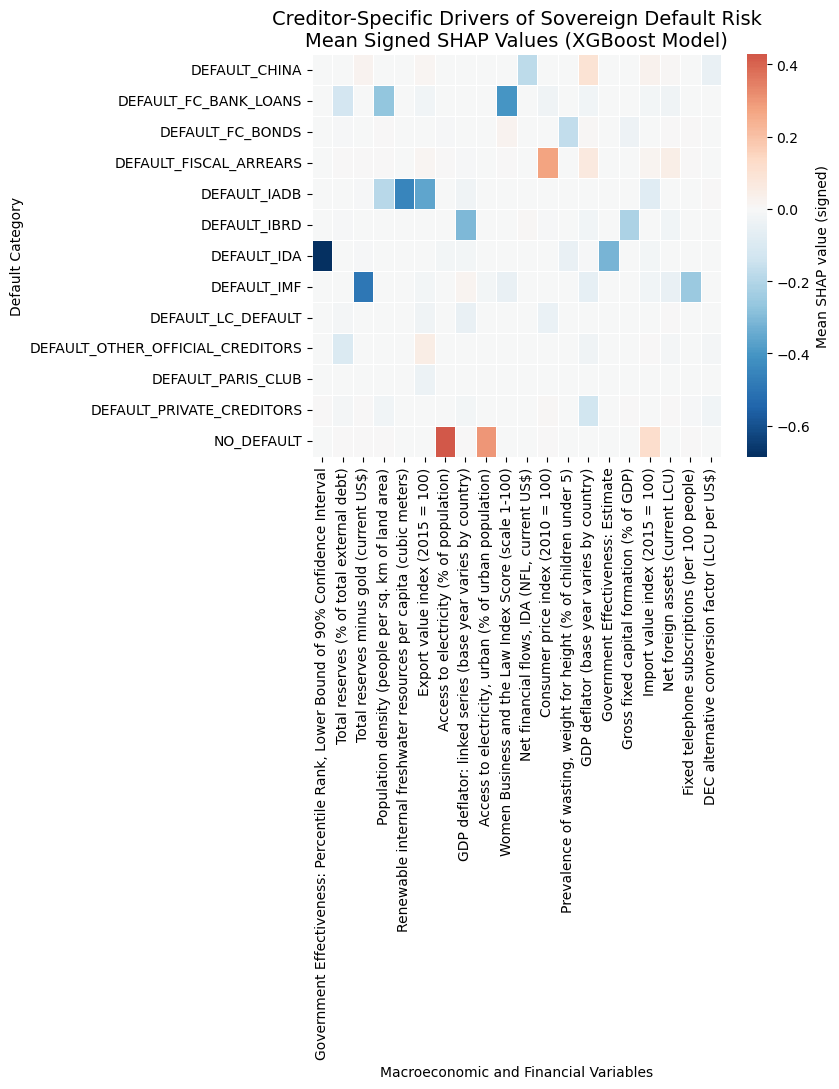

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar tipo numérico
heatmap_data = heatmap_data.astype(float)

plt.figure(figsize=(8.5, 11))  # tamaño carta en pulgadas

sns.heatmap(
    heatmap_data,
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Mean SHAP value (signed)"}
)

plt.title(
    "Creditor-Specific Drivers of Sovereign Default Risk\n"
    "Mean Signed SHAP Values (XGBoost Model)",
    fontsize=14
)

plt.xlabel("Macroeconomic and Financial Variables")
plt.ylabel("Default Category")

plt.tight_layout()
plt.show()
